In [4]:
import pickle
import jieba
import operator
import pandas as pd
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

font_path = 'msjh.ttc'

In [5]:
jieba.set_dictionary('dict.txt.big')
jieba.load_userdict('userdict.txt')

Building prefix dict from C:\Users\CM\Documents\NTU\TA\107 winter\Political-News-Analysis\dict.txt.big ...
Loading model from cache C:\Users\CM\AppData\Local\Temp\jieba.u86db03224454ab6d8bfe857614551ecc.cache
Loading model cost 3.273 seconds.
Prefix dict has been built succesfully.


In [6]:
with open('crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
    
contents = [news['content'] for news in data]

In [7]:
stopwords = []
with open('stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

stopwords[:10]

['\ufeff', '', '$', '0', '1', '2', '3', '4', '5', '6']

In [8]:
def remove_punctuation(content_string, user_pc=False):
    if(user_pc):
        punctuation = user_pc
    else:
        punctuation=list("!@#$%^&*()_+=-[]`~'\"|/\\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;{}\r\xa0\u3000、，。「」！？；：<>")
        
    for p in punctuation:
        content_string = content_string.replace(p, " ")
    return(content_string)

def remove_stopwords_from_dict(word_dict, stopwords):
    for w in stopwords:
        word_dict.pop(w, word_dict)
    return word_dict

def lcut_to_dict(lcut):
    word_dict = dict(Counter(lcut))
#     word_dict.pop(' ')
    return(remove_stopwords_from_dict(word_dict, stopwords))

def sort_dict_by_values(d):
    return(sorted(d.items(), key=lambda x: x[1], reverse=True))


In [285]:
def news_containing_keyword(keyword, news_list):
    return list(filter(lambda news: keyword in news, news_list))

def news_containing_keywords(keywords, news_list):
    news = news_list
    for keyword in keywords:
        news = news_containing_keyword(keyword, news)
        
    return news

## Coshow

In [296]:
coshow_dict = {}
cat_content = ' '.join(contents[:100])
clean_content = remove_punctuation(cat_content)
cut_content = jieba.lcut(clean_content)
cut_content = list(filter(lambda x: x!=' ', cut_content))
for i in range(len(cut_content)-1):
    wcw = cut_content[i] + cut_content[i+1]
    try:
        coshow_dict[wcw] = coshow_dict[wcw] + 1
    except:
        coshow_dict[wcw] = 1

sdbv = sort_dict_by_values(coshow_dict)

In [42]:
# # output possible words to txt
# import codecs
# list_sdbv = [x[0] for x in sdbv]
# with codecs.open('t.txt', 'w', 'utf-8') as f:
#     f.write('\n'.join(list_sdbv))

## Count words

In [305]:
def get_cutted_dict(list_of_news):
    cat = ' '.join(list_of_news)
    cat = remove_punctuation(cat)
    cutted = jieba.lcut(cat)
    return lcut_to_dict(cutted)

def first_n_words(cutted_dict, n, word_len=2, to=1000):
    sdbv = sort_dict_by_values(cutted_dict)
    return list(filter(lambda x: len(x[0])>=word_len and len(x[0])<=to, sdbv))[:n]

In [310]:
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair

[('台灣', 1715),
 ('民進黨', 1026),
 ('中國', 785),
 ('蔡英文', 770),
 ('國民黨', 769),
 ('蘇貞昌', 637),
 ('柯文哲', 615),
 ('臉書', 584),
 ('希望', 582),
 ('媒體', 567),
 ('九二共識', 561),
 ('韓國瑜', 556),
 ('一個', 552),
 ('高雄', 524),
 ('賴清德', 505),
 ('政治', 491),
 ('支持', 481),
 ('指出', 460),
 ('總統', 427),
 ('選舉', 395)]

In [303]:
cutted_dict = get_cutted_dict(contents)

In [306]:
# 重要人物
first_n_words(cutted_dict, 70, 3, 3)

[('民進黨', 8922),
 ('國民黨', 8420),
 ('柯文哲', 8153),
 ('韓國瑜', 6590),
 ('陳其邁', 4683),
 ('蔡英文', 3738),
 ('蘇貞昌', 3280),
 ('姚文智', 2973),
 ('候選人', 2946),
 ('侯友宜', 2665),
 ('丁守中', 2389),
 ('賴清德', 2362),
 ('記者會', 2286),
 ('台北市', 2082),
 ('行政院', 2033),
 ('馬英九', 1909),
 ('立法院', 1684),
 ('高雄市', 1525),
 ('林佳龍', 1482),
 ('新北市', 1478),
 ('吳敦義', 1389),
 ('中選會', 1379),
 ('支持者', 1378),
 ('促轉會', 1238),
 ('委員會', 1230),
 ('黃偉哲', 1170),
 ('盧秀燕', 1151),
 ('發言人', 1132),
 ('鄭文燦', 1112),
 ('年輕人', 1099),
 ('黃國昌', 1082),
 ('總統府', 1078),
 ('蔡總統', 1064),
 ('吳音寧', 1027),
 ('辦公室', 1011),
 ('11月', 966),
 ('台中市', 937),
 ('黨主席', 926),
 ('朱立倫', 878),
 ('教育部', 871),
 ('管中閔', 867),
 ('外交部', 854),
 ('習近平', 784),
 ('陳水扁', 746),
 ('基金會', 739),
 ('支持度', 706),
 ('參選人', 671),
 ('卓榮泰', 655),
 ('進一步', 649),
 ('涂醒哲', 639),
 ('游盈隆', 631),
 ('陳思宇', 630),
 ('總經理', 630),
 ('市議員', 627),
 ('農委會', 626),
 ('嘉義市', 613),
 ('王金平', 596),
 ('陸委會', 594),
 ('董事長', 567),
 ('12月', 562),
 ('副市長', 551),
 ('黨中央', 545),
 ('假新聞', 545),
 ('交通部', 540),
 ('10

In [307]:
# 重要事物
first_n_words(cutted_dict, 50, 4)

[('台北市長柯文哲', 1590),
 ('總統蔡英文', 1356),
 ('時代力量', 1135),
 ('九二共識', 1022),
 ('行政院長賴清德', 1003),
 ('中華民國', 852),
 ('競選總部', 779),
 ('蔡英文總統', 762),
 ('競選辦公室', 720),
 ('兩岸關係', 708),
 ('台灣人民', 696),
 ('轉型正義', 693),
 ('2020', 673),
 ('立委補選', 659),
 ('2018', 633),
 ('九合一選舉', 620),
 ('2014', 601),
 ('前總統馬英九', 598),
 ('兩岸一家親', 594),
 ('民進黨立委', 566),
 ('台北市長', 542),
 ('政治人物', 530),
 ('2018年', 481),
 ('民進黨台北市長', 467),
 ('候選人陳其邁', 466),
 ('台灣民主', 458),
 ('民進黨高雄市長', 458),
 ('深澳電廠', 444),
 ('候選人韓國瑜', 442),
 ('高雄市長', 435),
 ('造勢晚會', 428),
 ('台北市政府', 421),
 ('候選人姚文智', 418),
 ('國民黨立委', 412),
 ('競選團隊', 406),
 ('2016年', 403),
 ('行政院長', 401),
 ('一國兩制', 395),
 ('國民黨台北市長', 393),
 ('市長林佳龍', 393),
 ('國民黨主席吳敦義', 384),
 ('立法委員', 383),
 ('議員候選人', 360),
 ('台大校長', 358),
 ('台中市政府', 351),
 ('2020年', 346),
 ('國民黨高雄市長', 335),
 ('高雄市長韓國瑜', 334),
 ('民進黨執政', 329),
 ('媒體報導', 328)]

## Wordcloud

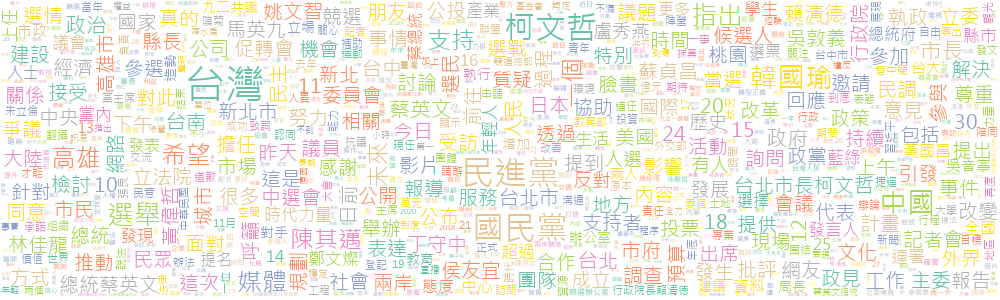

In [313]:
cutted_dict = get_cutted_dict(contents)
high_freq_pair = first_n_words(cutted_dict, 10000)

wc.generate_from_frequencies({word: freq for (word, freq) in high_freq_pair}).to_image()

In [260]:
def get_wordcloud_of_keyword(keyword, list_of_news, image_path=False):
    if image_path:
        coloring = np.array(Image.open(os.path.join(image_path)))
        color_func = ImageColorGenerator(coloring)
        wc = WordCloud(max_font_size=40,
                       background_color="white",
                       mask=coloring,
                       color_func=color_func,
                       font_path=font_path,
                       width=1000, height=1000,
                      max_words=10000)
    else:
        wc = WordCloud(max_font_size=40,
                       background_color="white",
                       colormap='Set2',
                       font_path=font_path,
                       width=1000, height=300,
                      max_words=1000)
    
    keyword_news = news_containing_keywords(keyword, list_of_news)
    keyword_dict = get_cutted_dict(keyword_news)
    print(len(keyword_dict))
    im = wc.generate_from_frequencies(keyword_dict)
    return im

## 熱門政治人物文字雲

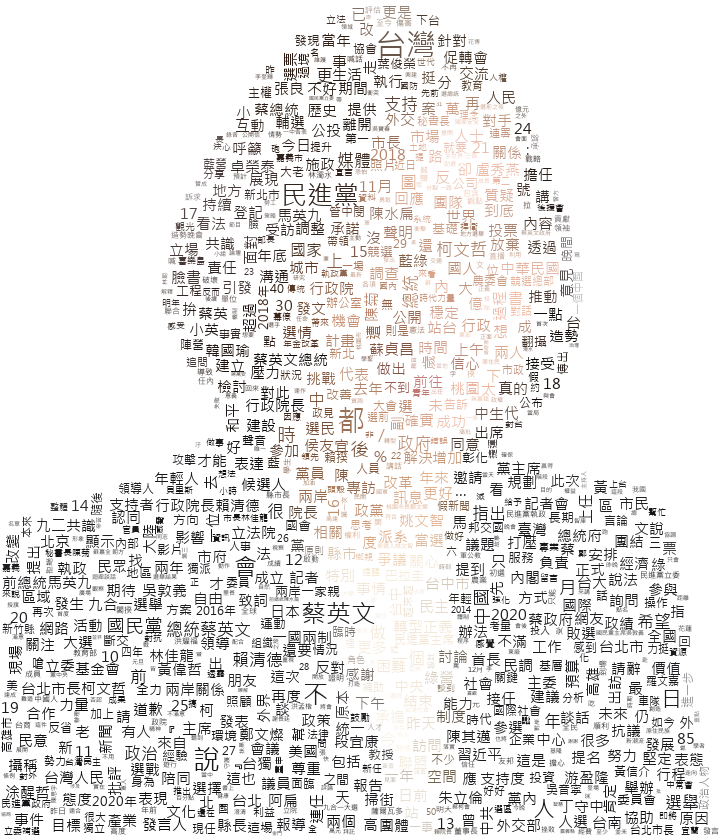

In [253]:
# 蔡英文
# ten_wc = get_wordcloud_of_keyword('蔡英文', contents, 'politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()

In [277]:
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 30)

[('台灣', 5039),
 ('民進黨', 3893),
 ('蔡英文', 3738),
 ('中國', 2136),
 ('國民黨', 2021),
 ('總統', 1643),
 ('柯文哲', 1616),
 ('支持', 1469),
 ('一個', 1407),
 ('總統蔡英文', 1356),
 ('選舉', 1303),
 ('希望', 1242),
 ('媒體', 1241),
 ('指出', 1226),
 ('賴清德', 1179),
 ('政府', 1150),
 ('政治', 1109),
 ('國家', 1041),
 ('未來', 975),
 ('人民', 925),
 ('蔡總統', 918),
 ('美國', 863),
 ('民眾', 849),
 ('接受', 805),
 ('改革', 792),
 ('這是', 788),
 ('市長', 788),
 ('蔡英文總統', 762),
 ('政策', 761),
 ('這次', 759)]

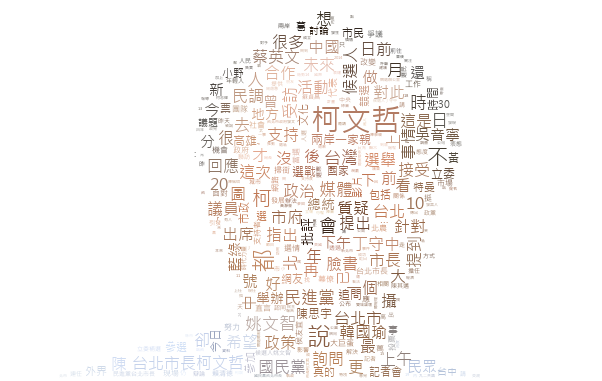

In [264]:
# 柯文哲
# kp_wc = get_wordcloud_of_keyword('柯文哲', contents, image_path='politicians/kp.png')
# kp_wc.to_file('politicians/kpwc.png')
kp_wc.to_image()

In [278]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 30)

[('柯文哲', 8153),
 ('媒體', 2356),
 ('姚文智', 2120),
 ('台灣', 2117),
 ('民進黨', 2107),
 ('丁守中', 1822),
 ('選舉', 1703),
 ('台北市長柯文哲', 1590),
 ('市長', 1538),
 ('國民黨', 1469),
 ('市府', 1395),
 ('一個', 1340),
 ('台北', 1291),
 ('台北市', 1254),
 ('中國', 1197),
 ('韓國瑜', 1120),
 ('支持', 1081),
 ('希望', 972),
 ('政治', 963),
 ('出席', 951),
 ('指出', 934),
 ('接受', 916),
 ('受訪', 864),
 ('活動', 825),
 ('上午', 805),
 ('質疑', 786),
 ('議員', 783),
 ('臉書', 762),
 ('回應', 737),
 ('候選人', 728)]

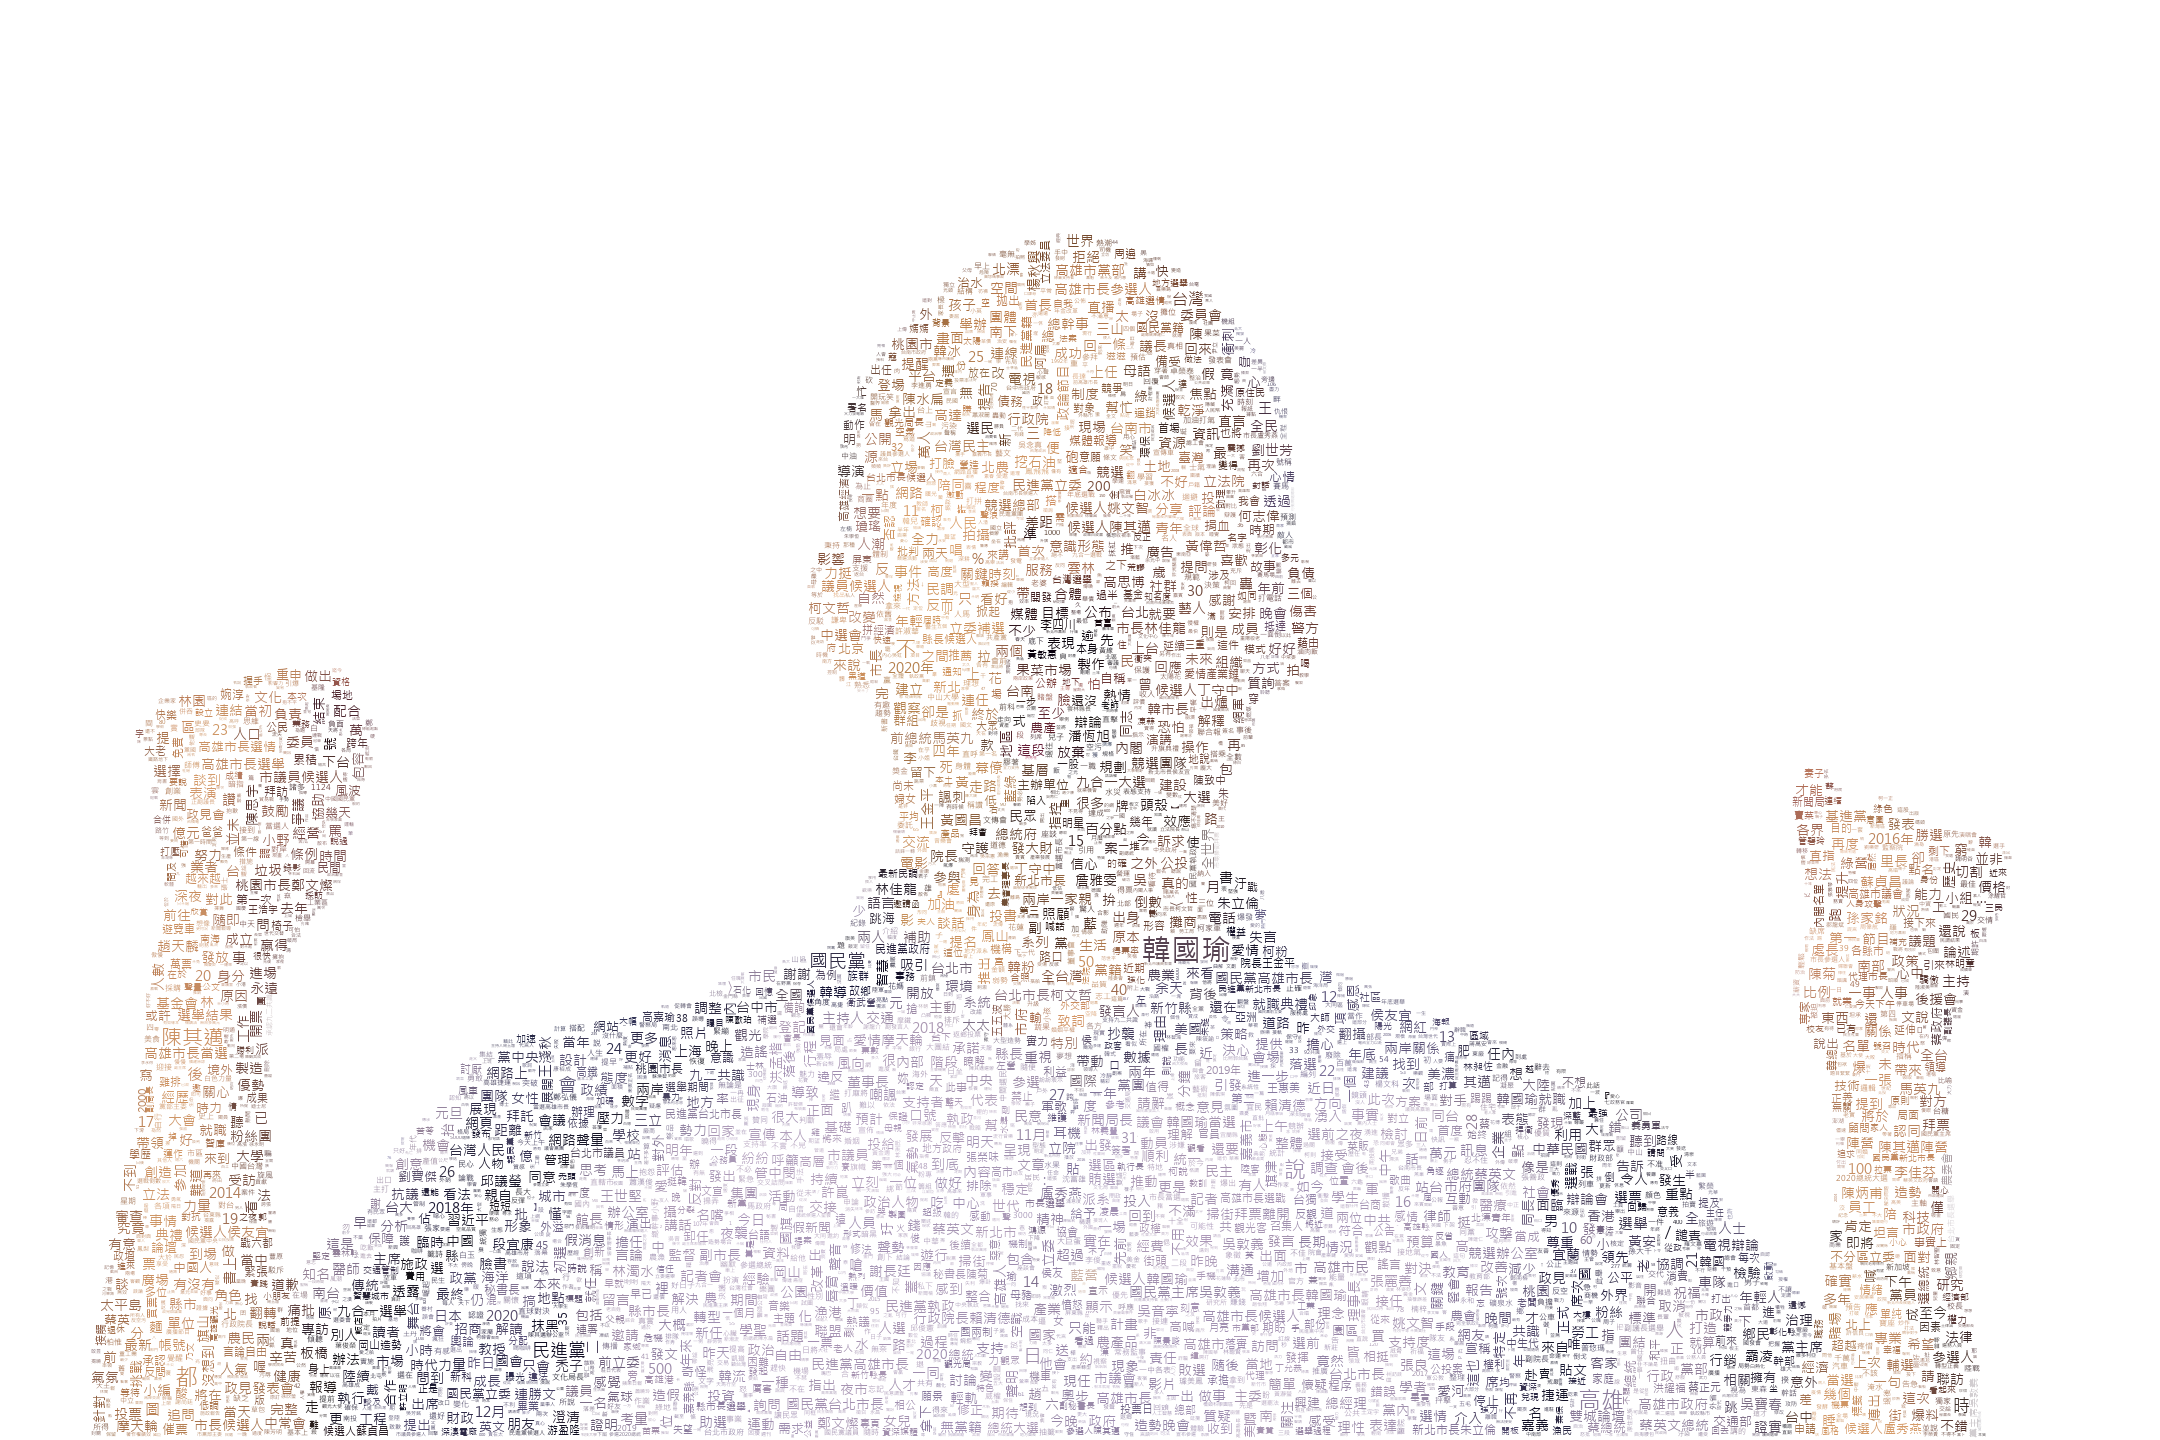

In [262]:
# 韓國瑜
# han_wc = get_wordcloud_of_keyword('韓國瑜', contents, 'politicians/han.png')
# han_wc.to_file('politicians/hanwc.png')
han_wc.to_image()

In [279]:
news_containing_han = news_containing_keyword('韓國瑜', contents)
han_dict = get_cutted_dict(news_containing_han)
first_n_words(han_dict, 30)

[('韓國瑜', 6590),
 ('高雄', 3259),
 ('陳其邁', 2644),
 ('國民黨', 2065),
 ('民進黨', 1740),
 ('台灣', 1518),
 ('選舉', 1304),
 ('柯文哲', 1166),
 ('網友', 1138),
 ('媒體', 1036),
 ('高雄市', 983),
 ('臉書', 914),
 ('市長', 912),
 ('支持', 894),
 ('一個', 890),
 ('指出', 875),
 ('希望', 843),
 ('候選人', 783),
 ('中國', 779),
 ('未來', 732),
 ('政治', 665),
 ('民眾', 662),
 ('民調', 612),
 ('10', 604),
 ('網路', 565),
 ('台北', 559),
 ('影片', 546),
 ('活動', 534),
 ('20', 528),
 ('這次', 528)]

24821


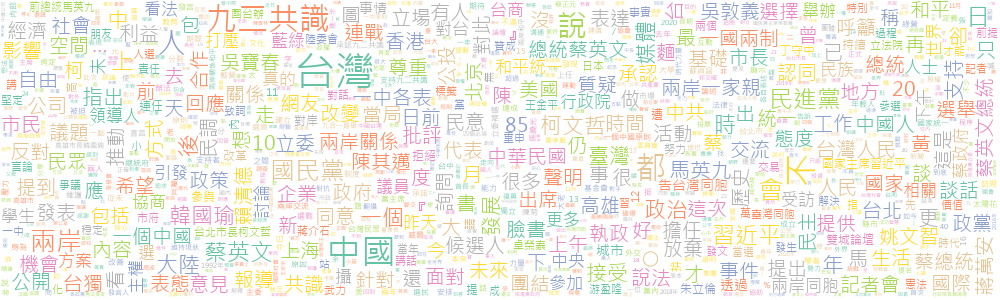

In [311]:
# 九二共識
nt_wc = get_wordcloud_of_keyword('九二共識', contents)
nt_wc.to_file('politicians/92.png')
nt_wc.to_image()

In [281]:
hot = '九二共識'
news_containing_hot = news_containing_keyword(hot, contents)
hot_dict = get_cutted_dict(news_containing_hot)
first_n_words(hot_dict, 30, 3) # 人名

[('九二共識', 1022),
 ('民進黨', 487),
 ('蔡英文', 467),
 ('國民黨', 465),
 ('習近平', 446),
 ('柯文哲', 379),
 ('韓國瑜', 346),
 ('一國兩制', 293),
 ('吳寶春', 287),
 ('兩岸關係', 266),
 ('馬英九', 253),
 ('兩岸一家親', 241),
 ('蔡總統', 182),
 ('中華民國', 178),
 ('姚文智', 176),
 ('一個中國', 159),
 ('中國人', 149),
 ('一中各表', 146),
 ('總統蔡英文', 142),
 ('蔡英文總統', 118),
 ('台灣人民', 117),
 ('吳敦義', 115),
 ('記者會', 113),
 ('蔣萬安', 92),
 ('兩岸同胞', 90),
 ('和平統一', 89),
 ('賴清德', 88),
 ('告台灣同胞', 80),
 ('領導人', 79),
 ('國家主席習近平', 78)]

In [289]:
hotP = news_containing_keywords([hot, '蔡英文'], contents)
hotP_dict = get_cutted_dict(hotP)
first_n_words(hotP_dict, 30, 2)

[('台灣', 952),
 ('中國', 739),
 ('九二共識', 655),
 ('蔡英文', 467),
 ('民進黨', 357),
 ('兩岸', 353),
 ('習近平', 337),
 ('國民黨', 286),
 ('一國兩制', 231),
 ('接受', 206),
 ('支持', 204),
 ('大陸', 201),
 ('媒體', 197),
 ('臺灣', 195),
 ('美國', 185),
 ('蔡總統', 169),
 ('馬英九', 169),
 ('總統', 168),
 ('指出', 165),
 ('柯文哲', 162),
 ('兩岸關係', 158),
 ('政治', 158),
 ('一個', 151),
 ('總統蔡英文', 142),
 ('發表', 141),
 ('85', 137),
 ('國家', 136),
 ('中華民國', 135),
 ('發展', 129),
 ('人民', 129)]

In [72]:
# coloring
# pic_path = 'politicians/kp.png'
# kp_coloring = np.array(Image.open(os.path.join(pic_path)))
# kp_coloring_func = ImageColorGenerator(kp_coloring)

# kpwc = WordCloud(max_font_size=30,
#                background_color="white",
#                mask=kp_coloring,
#                color_func=kp_coloring_func,
#                font_path=font_path,
#                width=1000, height=1000)

In [312]:
wc = WordCloud(max_font_size=40,
               background_color="white",
               colormap='Set2',
               font_path=font_path,
               width=1000, height=300,
              max_words=1000)

## TFIDF

In [315]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [325]:
ccontents = [remove_punctuation(news) for news in contents]

In [326]:
corpus = [' '.join(jieba.lcut(news)) for news in ccontents]

In [327]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
word = vectorizer.get_feature_names()

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)

In [328]:
pd.DataFrame(tfidf.toarray(), columns=word)

,00,000,0000,0001,0005030960009,001,0015,002,003,0039,...,龜山,龜山島,龜崙嶺,龜王,龜笑,龜縮,龜苓,龜苓膏,龜裂,龜速
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
